In [5]:
# Preparation
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, sin, cos, pi, arccos
import scipy.integrate as integrate
import scipy.special as special

import math

from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import RXGate

In [3]:
# Helper Functions 

def get_histogram(qc, shots=5000):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=shots)
    result = job.result()
    return result.get_counts()

# Norm(0, 1)
def norm(x):
    return (1/sqrt(2*pi))*np.exp(-x**2/2) 


## Grover-Rudolph Wavefunction Preparation
This function takes as input a log-concave distribution and encodes it into an n qubit circuit. 

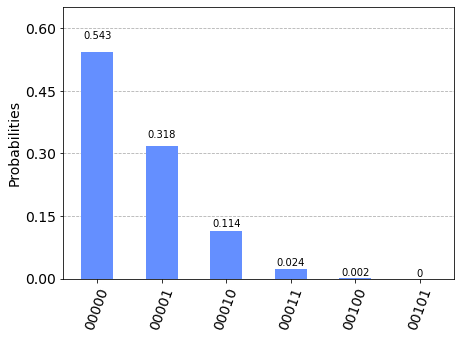

In [156]:
## TODO: 
#  - Figure out how to plot the 0 values too 
#  - Resolve the weird permutation stuff that's happening

def GRA(n, dist, a, b):
    """
    Grover Rudolph Wavefunction Preparation
    
    n: Number of qubits (precision)
    dist: Distribution (must be log-concave)
    a, b: Range of distribution
    """
    R = b - a
    F = []     # cos^2(angle) vector
    T = []     # Angle vector
    P = []     # Probability vector
    
    # Prepare the necessary vectors that store the probability of each wave in a given interval. 
    for m in range(0,n+1):
        F.append([])
        T.append([])
        P.append([])
        # Append array of size 2**m to each vector
        for i in range(0, 2**m):
            num_LB = a + (R / 2**m) * i       # Numerator lower bound
            num_UB = num_LB + (R / 2**(m+1))  # Numerator upper bound
            den_LB = a + (R / 2**m) * i       # Denominator lower bound
            den_UB = a + (R / 2**m) * (i+1)   # Denominator lower bound
            f = integrate.quad(dist, num_LB, num_UB)[0] / integrate.quad(dist, den_LB, den_UB)[0]
            t = arccos(sqrt(f))
            p = integrate.quad(dist, den_LB, den_UB)[0]
            F[m].append(f)
            T[m].append(t)
            P[m].append(p)
            
    # Construct the circuit
    qr = QuantumRegister(n,'q')
    cr = ClassicalRegister(n,'c')
    qc = QuantumCircuit(qr, cr)
    
    qc.rx(2*T[0][0], 0)
    
    for m in range(1, n):
        qc.barrier()
        control_qubits = []
        for i in range(0, m):
            control_qubits.append(qr[i])
        for i in range(0, 2**m):
            for j in range(0, m):
                if i & int(2**(j)) == False:
                    qc.x(m - j - 1)
                else:
                    pass
            qc.mcrx(2*T[m][i], control_qubits, qr[m])
            for j in range(0, m):
                if i & int(2**(j)) == False:
                    qc.x(m - j - 1)
    
    if (n % 2 == 0):
        for i in range(0, n//2):
            qc.swap(i, n-i-1)
    else:
        for i in range(0, (n-1)//2):
            qc.swap(i, n-i-1)
#     qc.swap(0, 3)
#     qc.swap(1, 2)
    return (qc, P)

n=5
(qc, P) = GRA(n, norm, 0, 24)
qr = QuantumRegister(n,'q')
cr = ClassicalRegister(n,'c')
qc.measure(qr,cr)
# print(P[-1])

plot_histogram(get_histogram(qc))
# qc.draw()